<a href="https://colab.research.google.com/github/MarkMinia/Project7/blob/main/Powerlifting_Machine_Learning_Final_KG_Total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload JSON file from Kaggle in order to access the dataset through the API without downloading it on my desktop
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Upload powerlifting data and unzip CSV
!kaggle datasets download -d open-powerlifting/powerlifting-database
!unzip /content/powerlifting-database.zip -d /content/

 92% 50.0M/54.1M [00:02<00:00, 28.7MB/s]
100% 54.1M/54.1M [00:02<00:00, 24.2MB/s]
Archive:  /content/powerlifting-database.zip
  inflating: /content/openpowerlifting.csv  


In [ ]:
# These will be used for the data wrangling
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# These will be used for the data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# These will be used to create thmachine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

# This will be used to evaluate the machine learning models
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create dataframe with CSV
df = pd.read_csv('openpowerlifting.csv')

In [ ]:
# Quick glance into the data
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [ ]:
# A look at all columns, missing values, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 37 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Event            1423354 non-null  object 
 3   Equipment        1423354 non-null  object 
 4   Age              757527 non-null   float64
 5   AgeClass         786800 non-null   object 
 6   Division         1415176 non-null  object 
 7   BodyweightKg     1406622 non-null  float64
 8   WeightClassKg    1410042 non-null  object 
 9   Squat1Kg         337580 non-null   float64
 10  Squat2Kg         333349 non-null   float64
 11  Squat3Kg         323842 non-null   float64
 12  Squat4Kg         3696 non-null     float64
 13  Best3SquatKg     1031450 non-null  float64
 14  Bench1Kg         499779 non-null   float64
 15  Bench2Kg         493486 non-null   float64
 16  Bench3Kg         4

In [ ]:
# Identify features that would help me answer my research question
df2 = df [['Deadlift1Kg', 'Bench1Kg', 'Squat1Kg', 'TotalKg', 'AgeClass', 'WeightClassKg', 'Sex', 'Event', 'Equipment', 'Tested']]

In [ ]:
# Filter values to only include SBD events
df3 = df2.loc[df2['Event'] == 'SBD'] 

In [ ]:
# Filter values to only include successful lifts resulting in a final total
lift = df3[df3['TotalKg'].notna()]

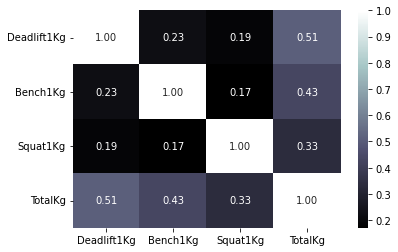

In [ ]:
# Look at correlation of features and TotalKg
sns.heatmap(lift.corr(), annot = True, fmt = '.2f', cmap = 'bone')

In [ ]:
# # Sort columns by the amount of missing values
lift.isnull().sum().sort_values(ascending = False)

Bench1Kg         668474
Squat1Kg         668321
Deadlift1Kg      668122
AgeClass         497315
Tested           188457
WeightClassKg      2452
TotalKg               0
Sex                   0
Event                 0
Equipment             0
dtype: int64

In [ ]:
# Quick glance into the new data frame
lift.head()

,Deadlift1Kg,Bench1Kg,Squat1Kg,TotalKg,AgeClass,WeightClassKg,Sex,Event,Equipment,Tested
0,110.0,45.0,80.0,290.0,24-34,60,F,SBD,Wraps,NaN
1,130.0,55.0,100.0,332.5,24-34,60,F,SBD,Wraps,NaN
3,132.5,67.5,-105.0,310.0,20-23,60,F,SBD,Wraps,NaN
4,150.0,70.0,120.0,390.0,45-49,110,F,SBD,Wraps,NaN
5,125.0,72.5,127.5,370.0,35-39,75,F,SBD,Wraps,NaN


In [ ]:
# Quick glance into AgeClass column
lift['AgeClass'].value_counts(dropna = False)

NaN       497315
24-34     155860
20-23      99321
18-19      47047
35-39      36171
40-44      33133
16-17      32952
45-49      22769
13-15      18041
50-54      17214
55-59       9901
60-64       6484
65-69       3609
70-74       2161
5-12        1286
75-79        827
80-999       238
Name: AgeClass, dtype: int64

In [ ]:
# Correct data value after finding the error 
lift['AgeClass'] = lift['AgeClass'].replace(['80-999'], '80-99')

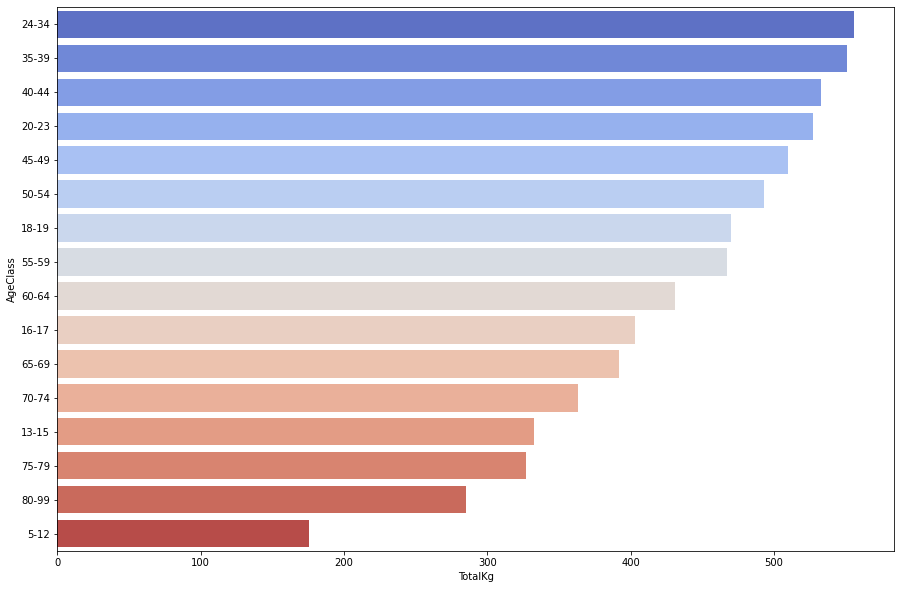

In [ ]:
# Difference in strength between age groups and the impact it has on a lifter's total
pd_lift1 = lift[['AgeClass', 'TotalKg']].groupby('AgeClass', as_index = False).mean().sort_values(by = 'TotalKg', ascending = False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = 'TotalKg', y = 'AgeClass', data = pd_lift1, orient = 'h', ci = None, palette = 'coolwarm')

In [ ]:
# Quick glance into WeightCLassKg column
lift['WeightClassKg'].value_counts(dropna = False)

75       62186
90       61498
100      54886
82.5     51275
67.5     40313
         ...  
117.5        1
81.5         1
122.5        1
76.5         1
56.7         1
Name: WeightClassKg, Length: 186, dtype: int64

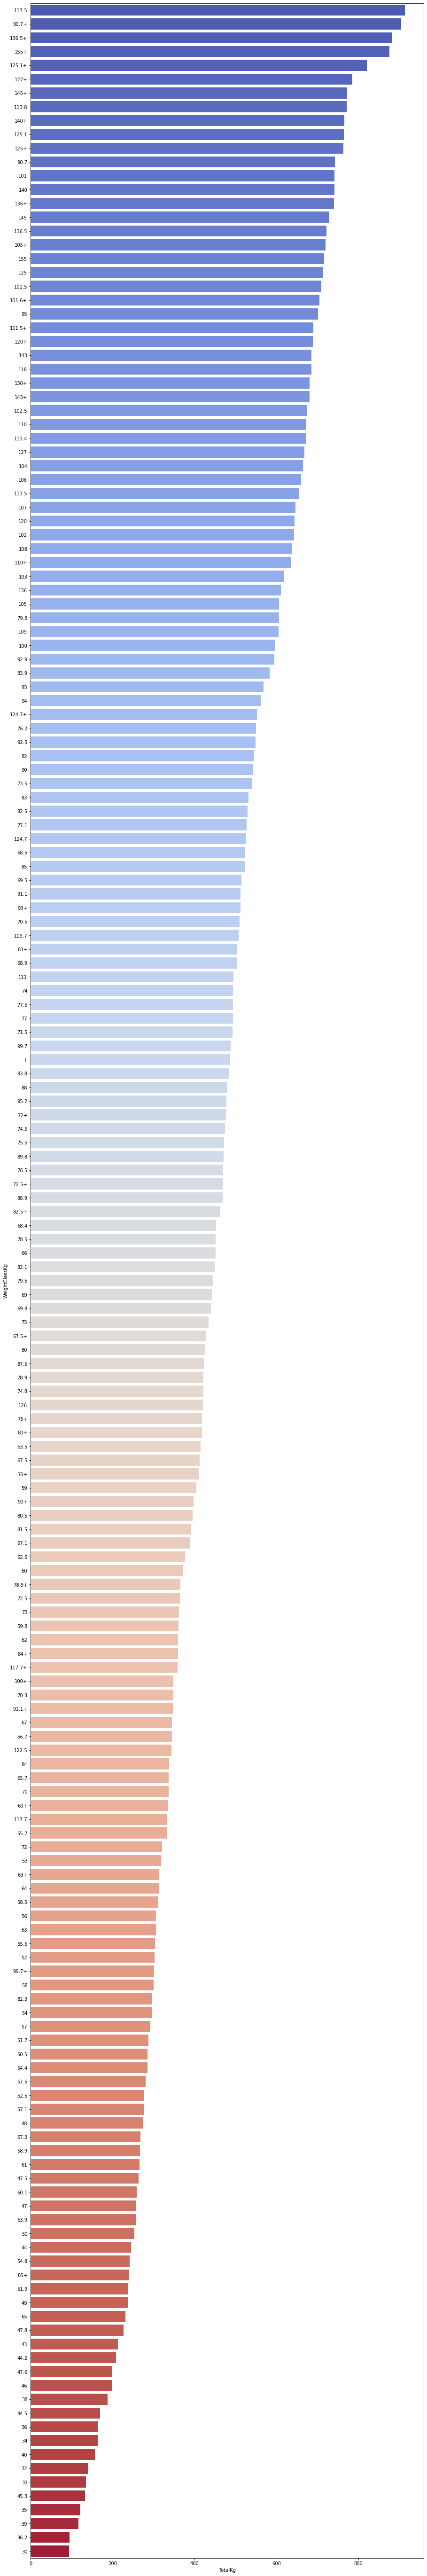

In [ ]:
# Difference in strength between weight classes and the impact it has on a lifter's total
pd_lift2 = lift[['WeightClassKg', 'TotalKg']].groupby('WeightClassKg', as_index = False).mean().sort_values(by = 'TotalKg', ascending = False)
fig, ax = plt.subplots(figsize=(15, 100))
sns.barplot(x = 'TotalKg', y = 'WeightClassKg', data = pd_lift2, orient = 'h', ci = None, palette = 'coolwarm')

In [ ]:
# Quick glance into Equipment column
lift['Equipment'].value_counts(dropna = False)

Single-ply    588517
Raw           270642
Wraps          98011
Multi-ply      27159
Name: Equipment, dtype: int64

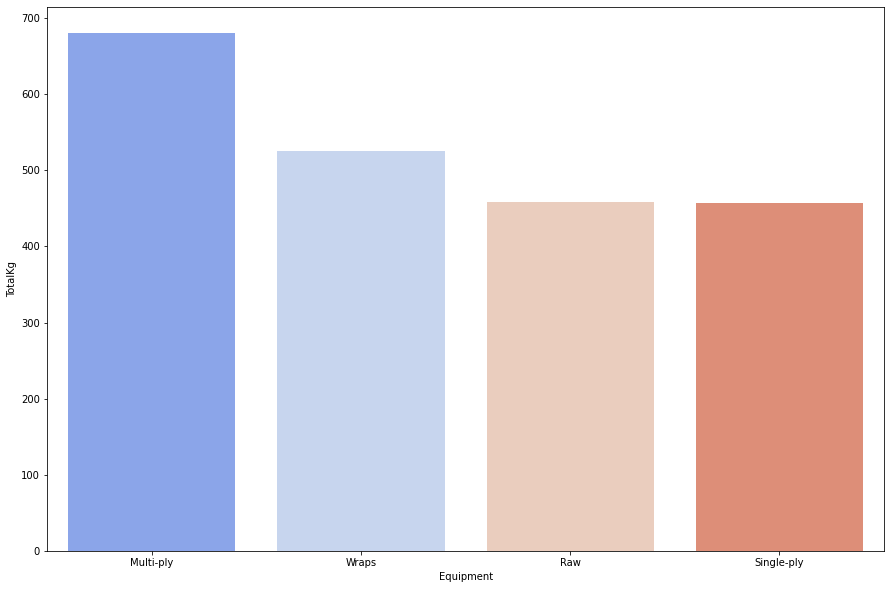

In [ ]:
# Difference in strength between choice of equipment and the impact it has on a lifter's total
pd_lift3 = lift[['Equipment', 'TotalKg']].groupby('Equipment', as_index = False).mean().sort_values(by = 'TotalKg', ascending = False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = 'Equipment', y = 'TotalKg', data = pd_lift3, ci = None, palette = 'coolwarm')

In [ ]:
# According to content information, the value is Yes if the lifter entered a drug-tested meet, but is otherwise if left blank, so No is to be filled in
lift['Tested'].value_counts(dropna = False)

Yes    795872
NaN    188457
Name: Tested, dtype: int64

In [ ]:
# Replace null values in Tested with No
lift[['Tested']] = lift[['Tested']].fillna('No')

In [ ]:
lift['Tested'].value_counts(dropna = False)

Yes    795872
No     188457
Name: Tested, dtype: int64

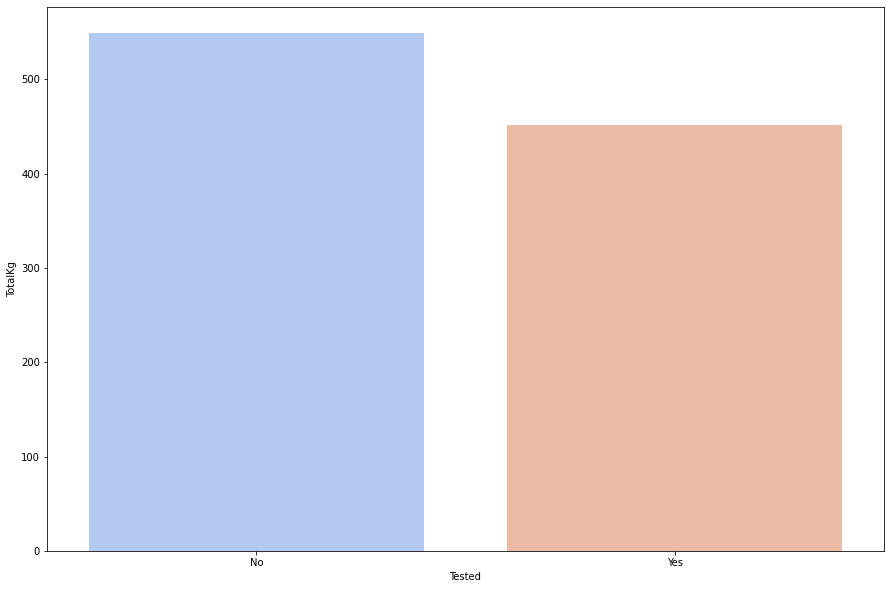

In [ ]:
# Difference in strength between choice of equipment and the impact it has on a lifter's total
pd_lift4 = lift[['Tested', 'TotalKg']].groupby('Tested', as_index = False).mean().sort_values(by = 'TotalKg', ascending = False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = 'Tested', y = 'TotalKg', data = pd_lift4, ci = None, palette = 'coolwarm')

In [ ]:
# Quick glance into Sex column
lift['Sex'].value_counts(dropna = False)

M    709011
F    275318
Name: Sex, dtype: int64

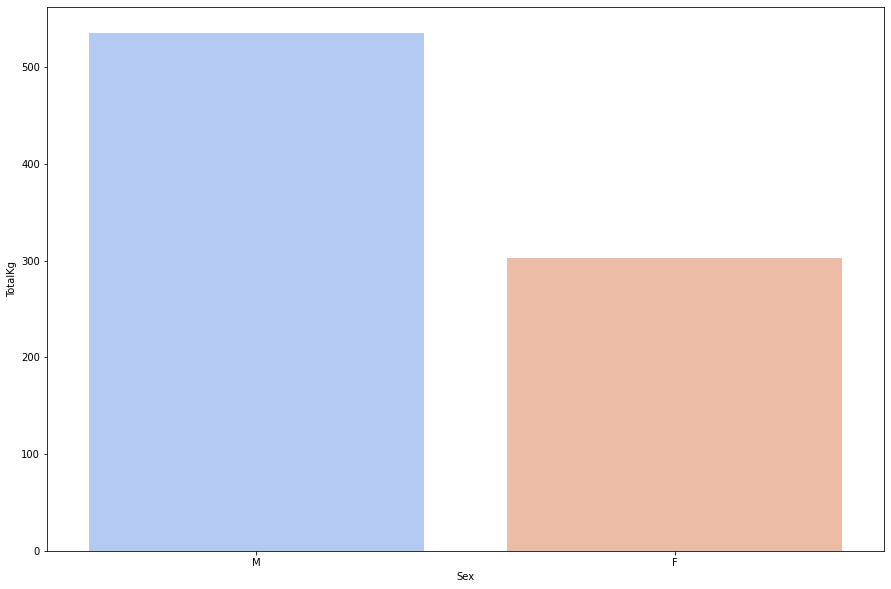

In [ ]:
# Difference in strength between gender and the impact it has on a lifter's total
pd_lift4 = lift[['Sex', 'TotalKg']].groupby('Sex', as_index = False).mean().sort_values(by = 'TotalKg', ascending = False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = 'Sex', y = 'TotalKg', data = pd_lift4, ci = None, palette = 'coolwarm')

In [ ]:
# Negative values indicate failed attempts, but it is not necessary as I only need to know what weight was selected for the opener; so we find the absolute values
lift[['Deadlift1Kg', 'Bench1Kg', 'Squat1Kg']] = df[['Deadlift1Kg', 'Bench1Kg', 'Squat1Kg']].abs()

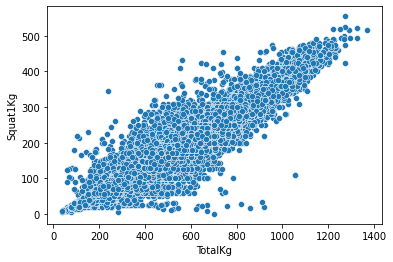

In [ ]:
# Trend of lighter openers correlating to smaller totals, and vice-versa
sns.scatterplot( data=lift, x='TotalKg', y='Squat1Kg')

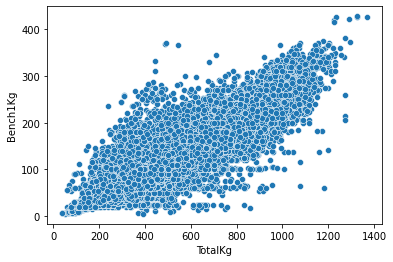

In [ ]:
sns.scatterplot( data=lift, x='TotalKg', y='Bench1Kg')

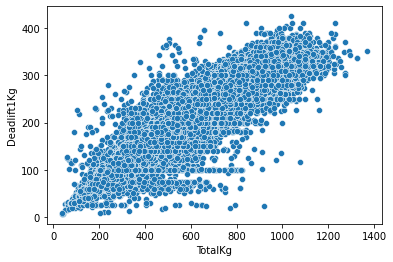

In [ ]:
sns.scatterplot( data=lift, x='TotalKg', y='Deadlift1Kg')

In [ ]:
# A look at the null values for and what needs to be imputed
lift.isnull().sum().sort_values(ascending = False)

Bench1Kg         668474
Squat1Kg         668321
Deadlift1Kg      668122
AgeClass         497315
WeightClassKg      2452
TotalKg               0
Sex                   0
Event                 0
Equipment             0
Tested                0
dtype: int64

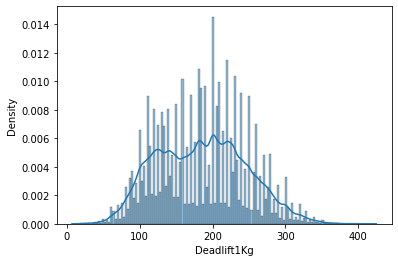

In [ ]:
# Graph the deadlift attempts to decide how to impute the missing values
sns.histplot(lift['Deadlift1Kg'], kde = True, stat = "density")

In [ ]:
# The mean was used to replace null values
mean = lift['Deadlift1Kg'].dropna().mean()
print(mean)

185.14553327408942


In [ ]:
lift['Deadlift1Kg'].fillna(mean, inplace = True)

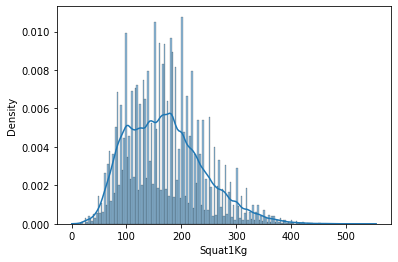

In [ ]:
# Graph the Squat attempts to decide how to impute the missing values
sns.histplot(lift['Squat1Kg'], kde = True, stat = "density")

In [ ]:
# The median was used to replace null values
median1 = lift['Squat1Kg'].dropna().median()
print(median1)

165.0


In [ ]:
lift['Squat1Kg'].fillna(median1, inplace = True)

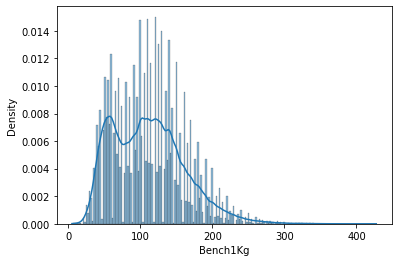

In [ ]:
# Graph the Squat attempts to decide how to impute the missing values
sns.histplot(lift['Bench1Kg'], kde = True, stat = "density")

In [ ]:
# The median was used to replace null values
median2 = lift['Bench1Kg'].dropna().median()
print(median2)

110.0


In [ ]:
lift['Bench1Kg'].fillna(median2, inplace = True)

In [ ]:
# The mode was used to replace null values because the AgeClass contains Objects
mode1 = lift['AgeClass'].dropna().mode()
print(mode1)

0    24-34
dtype: object


In [ ]:
lift['AgeClass'].fillna(df['AgeClass'].mode()[0], inplace=True)

In [ ]:
# The mode was used to replace null values because the AgeClass contains Objects
mode2 = lift['WeightClassKg'].dropna().mode()
print(mode2)

0    75
dtype: object


In [ ]:
lift['WeightClassKg'].fillna(df['WeightClassKg'].mode()[0], inplace=True)

In [ ]:
# Double-check there are no null values
lift.isnull().sum().sort_values(ascending = False)

Deadlift1Kg      0
Bench1Kg         0
Squat1Kg         0
TotalKg          0
AgeClass         0
WeightClassKg    0
Sex              0
Event            0
Equipment        0
Tested           0
dtype: int64

In [ ]:
# The goal is to predict the TotalKg using the opening weight selections and basic characteristics of the lifter
X = lift[['Deadlift1Kg', 'Bench1Kg', 'Squat1Kg', 'AgeClass', 'WeightClassKg', 'Sex', 'Equipment', 'Tested']]
y = lift[['TotalKg']]

In [ ]:
# One-hot encode AgeClass, WeightClassKg, Sex, Equipment, and Tested to prep for ML model
one_hot_encoded_data = pd.get_dummies(X, columns = ['AgeClass', 'WeightClassKg', 'Sex', 'Equipment', 'Tested'])
X = one_hot_encoded_data

In [ ]:
# Test-Train-Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.333, random_state = 42)

In [ ]:
# Linear Regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred1 = linreg.predict(X_test)
acc_lin = round(linreg.score(X_train, y_train) * 100, 2)
print ('Linear Regression Score =', acc_lin)

Linear Regression Score = 74.9


In [ ]:
# Linear Regression model evaluation
linreg_RMSE = MSE(y_test, y_pred1, squared = False)
linreg_r2 = r2_score(y_test, y_pred1)
print('Linear Regression RMSE =', linreg_RMSE)
print('Linear Regression R Squared =', linreg_r2)

Linear Regression RMSE = 86.1938674834214
Linear Regression R Squared = 0.7479917279148567


In [ ]:
# LGBM Regressor model
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred2 = lgbm.predict(X_test)
acc_lgbm = round(lgbm.score(X_train, y_train) * 100, 2)
print ('LGBMR Regressor Score =', acc_lgbm)

LGBMR Regressor Score = 80.87


In [ ]:
# LGBM Regressor model evaluation
lgbm_RMSE = MSE(y_test, y_pred2, squared = False)
lgbm_r2 = r2_score(y_test, y_pred2)
print('LGBMR Regressor RMSE =', lgbm_RMSE)
print('LGBMR Regressor R Squared =', lgbm_r2)

LGBMR Regressor RMSE = 75.18626382945419
LGBMR Regressor R Squared = 0.8082483676622738


In [ ]:
# Bayesian Ridge Regression model
bay = BayesianRidge()
bay.fit(X_train, y_train)
y_pred3 = bay.predict(X_test)
acc_bay = round(bay.score(X_train, y_train) * 100, 2)
print ('Bayesian Ridge Regression Score =', acc_bay)

Bayesian Ridge Regression Score = 74.9


In [ ]:
# Bayesian Ridge Regression model evaluation
bay_RMSE = MSE(y_test, y_pred3, squared = False)
bay_r2 = r2_score(y_test, y_pred3)
print('Bayesian Ridge Regression RMSE =', bay_RMSE)
print('Bayesian Ridge Regression R Squared =', bay_r2)

Bayesian Ridge Regression RMSE = 86.19359062286618
Bayesian Ridge Regression R Squared = 0.747993346847621


In [ ]:
# Elastic Net Regression model
enet = ElasticNet()
enet.fit(X_train, y_train)
y_pred4 = enet.predict(X_test)
acc_enet = round(enet.score(X_train, y_train) * 100, 2)
print ('Elastic Net Regression Score =', acc_enet)

Elastic Net Regression Score = 50.56


In [ ]:
# Elastic Net Regression evaluation
enet_RMSE = MSE(y_test, y_pred4, squared = False)
enet_r2 = r2_score(y_test, y_pred4)
print('Elastic Net Regression RMSE =', enet_RMSE)
print('Elastic Net Regression R Squared =', enet_r2)

Elastic Net Regression RMSE = 120.78662098570948
Elastic Net Regression R Squared = 0.5051202023388554


In [ ]:
models = pd.DataFrame({'Model': ['Linear Regression', 'LGBM Regressor', 'Bayesian Ridge Regression', 
                                 'Elastic Net Regression'],
                       'Score': [acc_lin, acc_lgbm, acc_bay, acc_enet],
                        'RMSE': [linreg_RMSE, lgbm_RMSE, bay_RMSE, enet_RMSE],
                       'R Squared': [linreg_r2, lgbm_r2, bay_r2, enet_r2]})


models.sort_values(by = ['Score', 'RMSE', 'R Squared'], ascending = [False, True, False], ignore_index = True)

,Model,Score,RMSE,R Squared
0,LGBM Regressor,80.87,75.186264,0.808248
1,Bayesian Ridge Regression,74.90,86.193591,0.747993
2,Linear Regression,74.90,86.193867,0.747992
3,Elastic Net Regression,50.56,120.786621,0.505120
